In [84]:
import pandas as pd
import numpy as np
import re

In [85]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [86]:
df = pd.read_csv("../Dataset/gurgaon_properties_cleaned_v1.csv")

In [87]:
df.duplicated().sum()
# df[df.duplicated()].sort_values(by="society")

122

In [88]:
# feature engineering -> areaWithType, additionalRoom, facing, agePossession, furnishDetails, features
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,ardee city,sector 52,1.55,7381.0,2100.0,Built Up area: 2100 (195.1 sq.m.)Carpet area: 1600 sq.ft. (148.64 sq.m.),4,4,3,not available,1.0,NaN,5 to 10 Year Old,NaN,"['1 Wardrobe', '1 Fan', '1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",NaN


## 1. areaWithType

In [89]:
df.sample(5)[["price", "area", "areaWithType"]]

,price,area,areaWithType
2283,0.82,1523.0,Super Built up area 1523(141.49 sq.m.)Built Up area: 1221.18 sq.ft. (113.45 sq.m.)
2060,1.65,1996.0,Carpet area: 1996 (185.43 sq.m.)
550,0.90,1950.0,Super Built up area 1950(181.16 sq.m.)Built Up area: 1900 sq.ft. (176.52 sq.m.)Carpet area: 1854 sq.ft. (172.24 sq.m.)
166,0.99,1488.0,Super Built up area 1991(184.97 sq.m.)Carpet area: 1495 sq.ft. (138.89 sq.m.)
2419,1.50,1400.0,Carpet area: 1400 (130.06 sq.m.)


In [90]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r"Super Built up area (\d+\.?\d*)", text)
    if match:
        return float(match.group(1))
    return None

In [91]:
# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r"\s*:\s*(\d+\.?\d*)", text)
    if match:
        return float(match.group(1))
    return None

In [92]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r"Plot area (\d+\.?\d*)", area_with_type)
    return float(match.group(1)) if match else None

In [93]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(
        r"{}\s*(?:sq\.ft.)?\s*\(\s*([\d.]+)\s*sq\.m\.".format(area_value), text
    )
    if match:
        sq_m_value = float(match.group(1))
        return round(sq_m_value * 10.7639)  # conversion factor from sq.m. to sqft
    return area_value

In [94]:
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df["super_built_up_area"] = df.apply(
    lambda x: convert_to_sqft(x["areaWithType"], x["super_built_up_area"]), axis=1
)

In [95]:
df["built_up_area"] = df["areaWithType"].apply(lambda x: get_area(x, "Built Up area"))
df["built_up_area"] = df.apply(
    lambda x: convert_to_sqft(x["areaWithType"], x["built_up_area"]), axis=1
)

In [96]:
df["carpet_area"] = df["areaWithType"].apply(lambda x: get_area(x, "Carpet area"))
df["carpet_area"] = df.apply(
    lambda x: convert_to_sqft(x["areaWithType"], x["carpet_area"]), axis=1
)

In [102]:
# all the column has values
df[
    ~(
        (df["super_built_up_area"].isnull())
        | (df["built_up_area"].isnull())
        | (df["carpet_area"].isnull())
    )
].shape

(534, 20)

In [99]:
all_nan_df = df[
    (
        (df["super_built_up_area"].isnull())
        & (df["built_up_area"].isnull())
        & (df["carpet_area"].isnull())
    )
]

In [103]:
all_nan_df["built_up_area"] = all_nan_df["areaWithType"].apply(extract_plot_area)

C:\Users\KIIT01\AppData\Local\Temp\ipykernel_9184\415975627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_nan_df["built_up_area"] = all_nan_df["areaWithType"].apply(extract_plot_area)


In [105]:
all_nan_df[
    [
        "price",
        "property_type",
        "area",
        "areaWithType",
        "super_built_up_area",
        "built_up_area",
        "carpet_area",
    ]
].head(30)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
14,6.50,house,2367.0,Plot area 263(219.9 sq.m.),NaN,263.0,NaN
16,7.00,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.0,NaN
23,6.50,house,1935.0,Plot area 215(179.77 sq.m.),NaN,215.0,NaN
26,5.00,house,3078.0,Plot area 342(285.96 sq.m.),NaN,342.0,NaN
41,6.00,house,2430.0,Plot area 270(225.75 sq.m.),NaN,270.0,NaN
48,25.00,house,8036.0,Plot area 1000(836.13 sq.m.),NaN,1000.0,NaN
53,4.00,house,1503.0,Plot area 167(139.63 sq.m.),NaN,167.0,NaN
69,11.58,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.0,NaN
72,3.20,house,2230.0,Plot area 2160(200.67 sq.m.),NaN,2160.0,NaN
80,27.50,house,11286.0,Plot area 1254(1048.5 sq.m.),NaN,1254.0,NaN


In [106]:
# convert to sq. ft.
def convert_scale(row):
    if np.isnan(row["area"]) or np.isnan(row["built_up_area"]):
        return row["built_up_area"]
    else:
        if round(row["area"] / row["built_up_area"]) == 9.0: # sq. yard
            return row["built_up_area"] * 9
        elif round(row["area"] / row["built_up_area"]) == 11.0: # sq.m
            return row["built_up_area"] * 10.7
        else:
            return row["built_up_area"]

In [107]:
all_nan_df["built_up_area"] = all_nan_df.apply(convert_scale, axis=1)

C:\Users\KIIT01\AppData\Local\Temp\ipykernel_9184\279311490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_nan_df["built_up_area"] = all_nan_df.apply(convert_scale, axis=1)


In [108]:
all_nan_df[
    [
        "price",
        "property_type",
        "area",
        "areaWithType",
        "super_built_up_area",
        "built_up_area",
        "carpet_area",
    ]
].head(30)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
14,6.50,house,2367.0,Plot area 263(219.9 sq.m.),NaN,2367.0,NaN
16,7.00,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.0,NaN
23,6.50,house,1935.0,Plot area 215(179.77 sq.m.),NaN,1935.0,NaN
26,5.00,house,3078.0,Plot area 342(285.96 sq.m.),NaN,3078.0,NaN
41,6.00,house,2430.0,Plot area 270(225.75 sq.m.),NaN,2430.0,NaN
48,25.00,house,8036.0,Plot area 1000(836.13 sq.m.),NaN,1000.0,NaN
53,4.00,house,1503.0,Plot area 167(139.63 sq.m.),NaN,1503.0,NaN
69,11.58,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.0,NaN
72,3.20,house,2230.0,Plot area 2160(200.67 sq.m.),NaN,2160.0,NaN
80,27.50,house,11286.0,Plot area 1254(1048.5 sq.m.),NaN,11286.0,NaN


In [109]:
df.update(all_nan_df)

In [110]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

## additionRooms

In [111]:
df["additionalRoom"].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
study room,servant room                            99
store room                                         99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 55
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              22
pooja room,others                                  17
pooja room,store room                              15
servant room,

In [112]:
new_cols = ["study room", "servant room", "store room", "pooja room", "others"]

for col in new_cols:
    df[col] = df["additionalRoom"].str.contains(col).astype(int)

In [114]:
df.sample(5)[
    [
        "additionalRoom",
        "study room",
        "servant room",
        "store room",
        "pooja room",
        "others",
    ]
]

,additionalRoom,study room,servant room,store room,pooja room,others
881,servant room,0,1,0,0,0
1131,not available,0,0,0,0,0
2910,not available,0,0,0,0,0
763,servant room,0,1,0,0,0
2636,"servant room,others",0,1,0,0,1


## 3.agePossession

In [115]:
df["agePossession"].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Jan 2024                 8
Oct 2024                 8
Aug 2023                 7
Dec 2025                 7
Jun 2024                 7
Nov 2023                 5
Sep 2023                 4
Jul 2024                 4
Aug 2024                 4
Oct 2023                 4
By 2025                  4
Nov 2024                 3
Feb 2024                 3
Jan 2025                 3
May 2024                 3
Mar 2025                 2
Aug 2025                 2
Jun 2027                 2
Sep 2025                 2
Dec 2026                 2
By 2027                  2
Oct 2025                 2
Jul 2027                 2
Jul 2025      

In [116]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if (
        "0 to 1 Year Old" in value
        or "Within 6 months" in value
        or "Within 3 months" in value
    ):
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [117]:
df["agePossession"] = df["agePossession"].apply(categorize_age_possession)

In [118]:
df["agePossession"].value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: count, dtype: int64

## 4.furnishDetails

In [119]:
df.sample(5)[["furnishDetails", "features"]]

,furnishDetails,features
302,"['1 Water Purifier', '24 Fan', '1 Exhaust Fan', '21 Geyser', '1 Stove', '51 Light', '24 AC', '1 Modular Kitchen', '1 Chimney', '24 Wardrobe', '1 Microwave', 'No Bed', 'No Curtains', 'No Dining Table', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine']","['Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'Park', 'Visitor Parking', 'Security Personnel', 'Waste Disposal', 'Rain Water Harvesting']"
3058,NaN,"['Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Rain Water Harvesting', 'Water softening plant']"
962,NaN,NaN
1142,"['4 Wardrobe', '5 Fan', '1 Exhaust Fan', '4 Geyser', '10 Light', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"
450,"['5 Wardrobe', '8 Fan', '1 Exhaust Fan', '5 Geyser', '18 Light', '8 AC', '1 Modular Kitchen', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'No open drainage around', 'Recently Renovated', 'Visitor Parking', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']"


In [120]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df["furnishDetails"].dropna():
    furnishings = detail.replace("[", "").replace("]", "").replace("'", "").split(", ")
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))


# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0


# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [
    re.sub(r"No |\d+", "", furnishing).strip() for furnishing in unique_furnishings
]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [
    furnishing for furnishing in columns_to_include if furnishing
]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df["furnishDetails"].apply(
        lambda x: get_furnishing_count(x, furnishing)
    )

# Create the new dataframe with the required columns
furnishings_df = df[["furnishDetails"] + columns_to_include]

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
C:\Users\KIIT01\AppData\Local\Temp\ipykernel_9184\2231566722.py:14: SyntaxWarning: invalid escape sequence '\d'
  pattern = re.compile(f"(\d+) {furnishing}")


In [121]:
furnishings_df.shape

(3803, 19)

In [122]:
furnishings_df.drop(columns=["furnishDetails"], inplace=True)

C:\Users\KIIT01\AppData\Local\Temp\ipykernel_9184\924765855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=["furnishDetails"], inplace=True)


In [123]:
furnishings_df.sample(5)

,Stove,Wardrobe,Microwave,Bed,Modular Kitchen,Fan,Light,Fridge,TV,Sofa,Chimney,AC,Water Purifier,Curtains,Geyser,Dining Table,Exhaust Fan,Washing Machine
3439,1,3,1,0,1,5,12,1,1,1,1,5,1,4,1,1,1,0
1985,1,4,0,0,1,10,0,0,0,0,1,0,0,0,5,0,1,0
1304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
712,1,21,1,0,1,20,62,0,0,0,1,12,1,0,16,0,1,0
1648,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [125]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [126]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [127]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

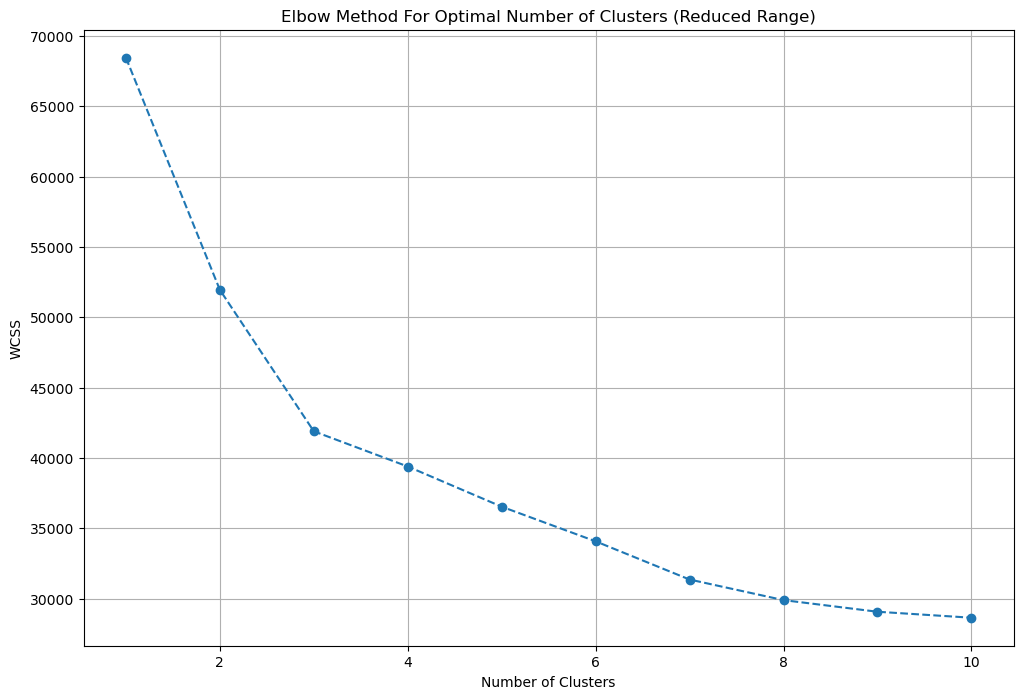

In [128]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), wcss_reduced, marker="o", linestyle="--")
plt.title("Elbow Method For Optimal Number of Clusters (Reduced Range)")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

In [129]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [ ]:
df.info()

In [130]:
df = df.iloc[:, :-18]

In [131]:
df["furnishing_type"] = cluster_assignments

In [132]:
df.sample(5)[["furnishDetails", "furnishing_type"]]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
163,"['7 Wardrobe', '12 Fan', '1 Exhaust Fan', '7 Geyser', '19 Light', '10 AC', '2 Chimney', '8 Curtains', '1 Modular Kitchen', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",2
2581,NaN,1
2969,"['3 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1
2699,NaN,1
634,"['3 Wardrobe', '3 Fan', '4 Light', '3 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",1


In [134]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type
0,flat,ardee city,sector 52,1.55,7381.0,2100.0,Built Up area: 2100 (195.1 sq.m.)Carpet area: 1600 sq.ft. (148.64 sq.m.),4,4,3,not available,1.0,NaN,Moderately Old,NaN,"['1 Wardrobe', '1 Fan', '1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",NaN,NaN,2100.0,1600.0,0,0,0,0,0,1


## 5.features

In [133]:
df[["society", "features"]].sample(5)

,society,features
1345,mapsko mount ville,"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"
2462,ireo skyon,"['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
3530,m3m soulitude,"['Intercom Facility', 'Lift(s)', 'Piped-gas', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Shopping Centre', 'Fitness Centre / GYM', 'Rain Water Harvesting', 'Club house / Community Center', 'Water softening plant']"
1148,bestech park view ananda,"['Intercom Facility', 'Lift(s)', 'Swimming Pool', 'Security Personnel', 'Maintenance Staff', 'Park', 'Club house / Community Center', 'Fitness Centre / GYM', 'Rain Water Harvesting', 'Shopping Centre']"
29,vatika emilia floors,"['Centrally Air Conditioned', 'Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"


In [135]:
df["features"].isnull().sum()

635

In [136]:
app_df = pd.read_csv("../Dataset/appartments.csv")
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Palam Vihar', 'Park Hospital', 'Gurgaon Railway Station']","{'Bajghera Road': '800 Meter', 'Palam Vihar Halt': '2.5 KM', 'DPSG Palam Vihar': '3.1 KM', 'Park Hospital': '3.1 KM', 'Gurgaon Railway Station': '4.9 KM', 'The NorthCap University': '5.4 KM', 'Dwarka Expy': '1.2 KM', 'Hyatt Place Gurgaon Udyog Vihar': '7.7 KM', 'Dwarka Sector 21, Metro Station': '7.2 KM', 'Pacific D21 Mall': '7.4 KM', 'Indira Gandhi International Airport': '14.7 KM', 'Hamoni Golf Camp': '6.2 KM', 'Fun N Food Waterpark': '8.8 KM', 'Accenture DDC5': '9 KM'}",https://www.99acres.com/smartworld-one-dxp-sector-113-gurgaon-npxid-r400415,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,370 sq.ft.', 'price-range': '₹ 2 - 2.4 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,850 - 2,050 sq.ft.', 'price-range': '₹ 2.25 - 3.59 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '2,600 sq.ft.', 'price-range': '₹ 3.24 - 4.56 Cr'}}","['Swimming Pool', 'Salon', 'Restaurant', 'Spa', 'Cafeteria', 'Sun Deck', '24x7 Security', 'Club House', 'Gated Community']"
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap University', 'Park Hospital, Palam Vihar', 'Pacific D21 Mall', 'Palam Vihar Halt Railway Station']","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The NorthCap University': '4.4 Km', 'Park Hospital, Palam Vihar': '1.4 Km', 'Pacific D21 Mall': '8.2 Km', 'Palam Vihar Halt Railway Station': '1.2 Km', 'Dwarka Sector 21 Metro Station': '8.1 Km', 'Dwarka Expressway': '450 m', 'Fun N Food Water Park': '8.1 Km', 'Indira Gandhi International Airport': '14.1 Km', 'Tau DeviLal Sports Complex': '11.2 Km', 'Hamoni Golf Camp': '5 Km', 'Hyatt Place': '6.1 Km', 'Altrade Business Centre': '11.2 Km'}",https://www.99acres.com/m3m-crown-sector-111-gurgaon-npxid-r404068,"{'3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,605 - 2,170 sq.ft.', 'price-range': '₹ 2.2 - 3.03 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '2,248 - 2,670 sq.ft.', 'price-range': '₹ 3.08 - 3.73 Cr'}}","['Bowling Alley', 'Mini Theatre', 'Manicured Garden', 'Swimming Pool', 'Flower Garden', 'Reading Lounge', 'Golf Course', 'Barbecue', 'Sauna']"


In [137]:
app_df["PropertyName"] = app_df["PropertyName"].str.lower()

In [138]:
temp_df = df[df["features"].isnull()]
temp_df.shape

(635, 26)

In [139]:
x = temp_df.merge(app_df, left_on="society", right_on="PropertyName", how="left")[
    "TopFacilities"
]

In [140]:
df.loc[temp_df.index, "features"] = x.values

In [141]:
df["features"].isnull().sum()

481

In [142]:
import ast
# Convert the string representation of lists in the 'features' column to actual lists
df["features_list"] = df["features"].apply(
    lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith("[") else []
)

In [145]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df["features_list"])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [146]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
374,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2370,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0


In [147]:
weights = {
    "24/7 Power Backup": 8,
    "24/7 Water Supply": 4,
    "24x7 Security": 7,
    "ATM": 4,
    "Aerobics Centre": 6,
    "Airy Rooms": 8,
    "Amphitheatre": 7,
    "Badminton Court": 7,
    "Banquet Hall": 8,
    "Bar/Chill-Out Lounge": 9,
    "Barbecue": 7,
    "Basketball Court": 7,
    "Billiards": 7,
    "Bowling Alley": 8,
    "Business Lounge": 9,
    "CCTV Camera Security": 8,
    "Cafeteria": 6,
    "Car Parking": 6,
    "Card Room": 6,
    "Centrally Air Conditioned": 9,
    "Changing Area": 6,
    "Children's Play Area": 7,
    "Cigar Lounge": 9,
    "Clinic": 5,
    "Club House": 9,
    "Concierge Service": 9,
    "Conference room": 8,
    "Creche/Day care": 7,
    "Cricket Pitch": 7,
    "Doctor on Call": 6,
    "Earthquake Resistant": 5,
    "Entrance Lobby": 7,
    "False Ceiling Lighting": 6,
    "Feng Shui / Vaastu Compliant": 5,
    "Fire Fighting Systems": 8,
    "Fitness Centre / GYM": 8,
    "Flower Garden": 7,
    "Food Court": 6,
    "Foosball": 5,
    "Football": 7,
    "Fountain": 7,
    "Gated Community": 7,
    "Golf Course": 10,
    "Grocery Shop": 6,
    "Gymnasium": 8,
    "High Ceiling Height": 8,
    "High Speed Elevators": 8,
    "Infinity Pool": 9,
    "Intercom Facility": 7,
    "Internal Street Lights": 6,
    "Internet/wi-fi connectivity": 7,
    "Jacuzzi": 9,
    "Jogging Track": 7,
    "Landscape Garden": 8,
    "Laundry": 6,
    "Lawn Tennis Court": 8,
    "Library": 8,
    "Lounge": 8,
    "Low Density Society": 7,
    "Maintenance Staff": 6,
    "Manicured Garden": 7,
    "Medical Centre": 5,
    "Milk Booth": 4,
    "Mini Theatre": 9,
    "Multipurpose Court": 7,
    "Multipurpose Hall": 7,
    "Natural Light": 8,
    "Natural Pond": 7,
    "Park": 8,
    "Party Lawn": 8,
    "Piped Gas": 7,
    "Pool Table": 7,
    "Power Back up Lift": 8,
    "Private Garden / Terrace": 9,
    "Property Staff": 7,
    "RO System": 7,
    "Rain Water Harvesting": 7,
    "Reading Lounge": 8,
    "Restaurant": 8,
    "Salon": 8,
    "Sauna": 9,
    "Security / Fire Alarm": 9,
    "Security Personnel": 9,
    "Separate entry for servant room": 8,
    "Sewage Treatment Plant": 6,
    "Shopping Centre": 7,
    "Skating Rink": 7,
    "Solar Lighting": 6,
    "Solar Water Heating": 7,
    "Spa": 9,
    "Spacious Interiors": 9,
    "Squash Court": 8,
    "Steam Room": 9,
    "Sun Deck": 8,
    "Swimming Pool": 8,
    "Temple": 5,
    "Theatre": 9,
    "Toddler Pool": 7,
    "Valet Parking": 9,
    "Video Door Security": 9,
    "Visitor Parking": 7,
    "Water Softener Plant": 7,
    "Water Storage": 7,
    "Water purifier": 7,
    "Yoga/Meditation Area": 7,
}
# Calculate luxury score for each row
luxury_score = (
    features_binary_df[list(weights.keys())]
    .multiply(list(weights.values()))
    .sum(axis=1)
)

In [148]:
df["luxury_score"] = luxury_score

In [153]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
0,flat,ardee city,sector 52,1.55,7381.0,2100.0,Built Up area: 2100 (195.1 sq.m.)Carpet area: 1600 sq.ft. (148.64 sq.m.),4,4,3,1.0,NaN,Moderately Old,NaN,2100.0,1600.0,0,0,0,0,0,1,0


In [149]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(
    columns=[
        "nearbyLocations",
        "furnishDetails",
        "features",
        "features_list",
        "additionalRoom",
    ],
    inplace=True,
)

In [150]:
df.shape

(3803, 23)

In [151]:
df.to_csv("../Dataset/gurgaon_properties_cleaned_v2.csv", index=False)